In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris, corner_peaks
from skimage.transform import AffineTransform, warp
from scipy.spatial.distance import cdist
import glob
import random


In [4]:
image_paths = glob.glob("unstitched/*.jpg")



In [5]:
images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        images.append(img)
    else:
        print(f"Failed to load image at: {path}")

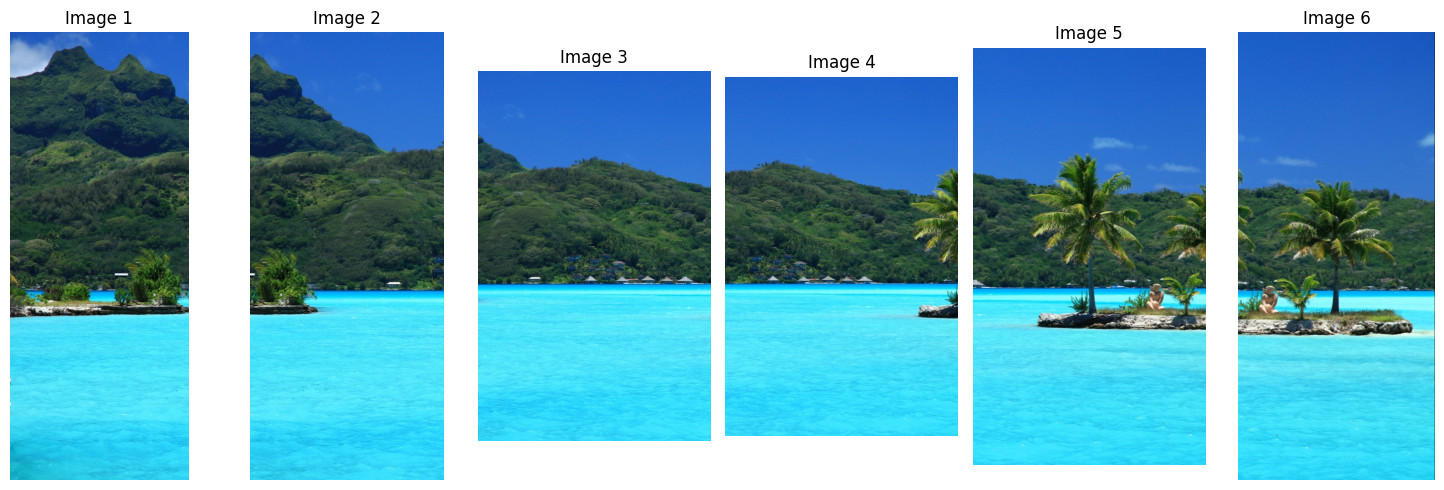

In [6]:

plt.figure(figsize=(15, 5))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
plt.tight_layout()
plt.show()

In [7]:
image = images[0]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)


In [8]:
harris_response = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
harris_response = cv2.dilate(harris_response, None)

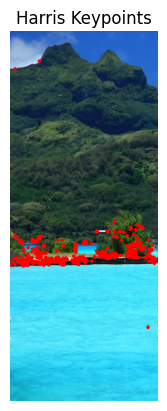

In [9]:

threshold = 0.01 * harris_response.max()
keypoints = np.argwhere(harris_response > threshold)  

vis_image = image.copy()
for y, x in keypoints:
    cv2.circle(vis_image, (x, y), 2, (255, 0, 0), -1)

plt.imshow(vis_image)
plt.title("Harris Keypoints")
plt.axis("off")
plt.show()

Patch size 5x5: Extracted 3636 patches
Patch size 11x11: Extracted 3627 patches
Patch size 15x15: Extracted 3599 patches


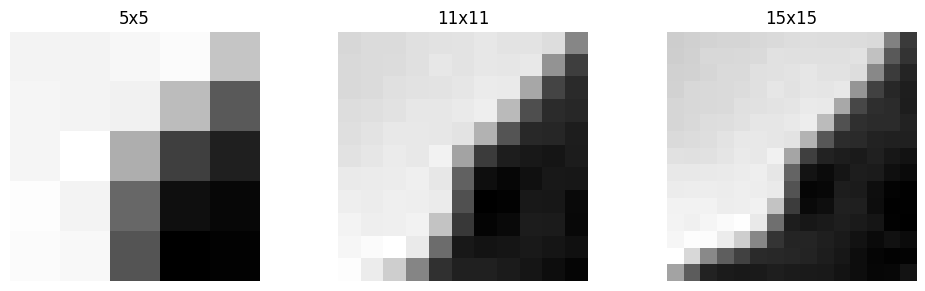

In [10]:
def extract_patches(gray_img, keypoints, patch_size):
    patches = []
    half = patch_size // 2
    for y, x in keypoints:
        if y-half >= 0 and y+half < gray_img.shape[0] and x-half >= 0 and x+half < gray_img.shape[1]:
            patch = gray_img[y-half:y+half+1, x-half:x+half+1]
            patches.append(patch)
    return patches

patch_sizes = [5, 11, 15]
patches_by_size = {}

for size in patch_sizes:
    patches = extract_patches(gray, keypoints, size)
    patches_by_size[size] = patches
    print(f"Patch size {size}x{size}: Extracted {len(patches)} patches")

plt.figure(figsize=(10, 3))
for i, size in enumerate(patch_sizes):
    plt.subplot(1, len(patch_sizes), i+1)
    if len(patches_by_size[size]) > 0:
        plt.imshow(patches_by_size[size][0], cmap='gray')
        plt.title(f'{size}x{size}')
        plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
def detect_harris_corners(image_rgb, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01, visualize=True):
    
    # Convert to grayscale and float32
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)

    # Harris corner detection
    harris_response = cv2.cornerHarris(gray, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)

    # Thresholding
    threshold = threshold_ratio * harris_response.max()
    keypoints = np.argwhere(harris_response > threshold)

    if visualize:
        vis_image = image_rgb.copy()
        for y, x in keypoints:
            cv2.circle(vis_image, (x, y), 2, (255, 0, 0), -1)
        plt.imshow(vis_image)
        plt.title("Harris Keypoints")
        plt.axis("off")
        plt.show()

    return keypoints, harris_response


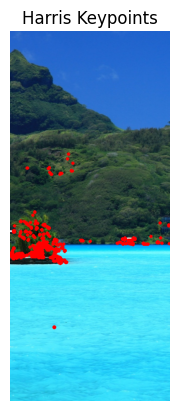

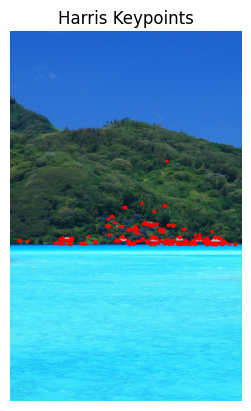

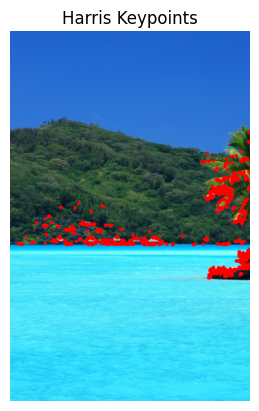

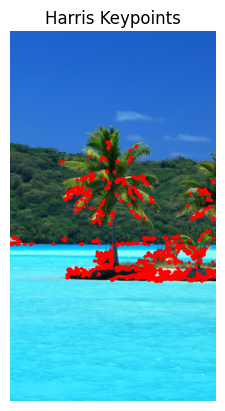

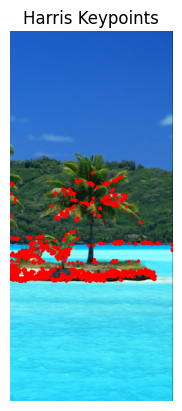

In [12]:
keypoints, response_map = detect_harris_corners(images[1])
keypoints, response_map = detect_harris_corners(images[2])
keypoints, response_map = detect_harris_corners(images[3])
keypoints, response_map = detect_harris_corners(images[4])
keypoints, response_map = detect_harris_corners(images[5])

In [13]:
import cv2
import numpy as np

def compute_sift_descriptors_from_harris(gray_img, harris_keypoints, patch_size=5):
    
    # Convert to OpenCV KeyPoints
    keypoints_cv2 = [cv2.KeyPoint(x=float(x), y=float(y), size=patch_size) for (y, x) in harris_keypoints]

    # Create SIFT object
    sift = cv2.SIFT_create()

    # Compute descriptors at those keypoints
    keypoints_cv2, descriptors = sift.compute(gray_img, keypoints_cv2)

    return keypoints_cv2, descriptors


Processing image 0...


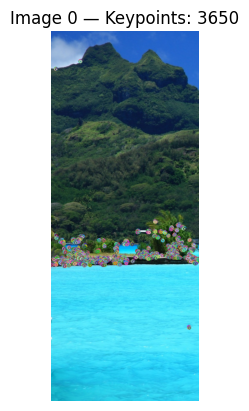

Processing image 1...


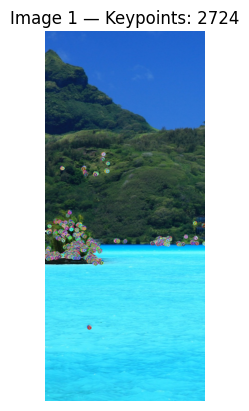

Processing image 2...


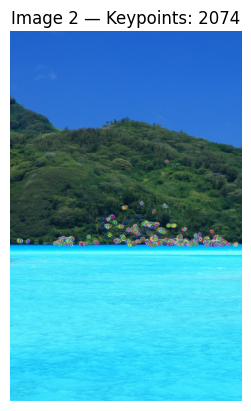

Processing image 3...


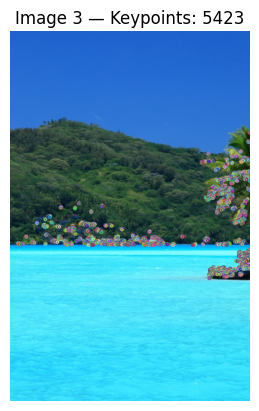

Processing image 4...


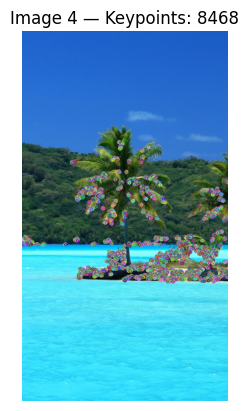

Processing image 5...


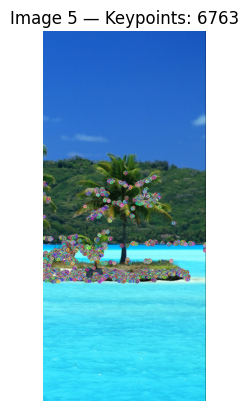

In [14]:
sift_kps_all = []       # List to store keypoints for all images
sift_descs_all = []     # List to store descriptors for all images
gray_images = []        # Store grayscale versions (optional)
images_with_kp = []     # Store images with keypoints drawn

for idx, img in enumerate(images):
    print(f"Processing image {idx}...")

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = np.uint8(gray)
    gray_images.append(gray)

    # Harris corner detection
    harris = cv2.cornerHarris(np.float32(gray), 2, 3, 0.04)
    harris = cv2.dilate(harris, None)
    threshold = 0.01 * harris.max()
    keypoints_harris = np.argwhere(harris > threshold)

    # Compute SIFT descriptors
    kp, desc = compute_sift_descriptors_from_harris(gray, keypoints_harris)

    # Store results
    sift_kps_all.append(kp)
    sift_descs_all.append(desc)

    # Draw keypoints on original image for visualization
    img_with_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    images_with_kp.append(img_with_kp)

    # Optional: show each one (you can comment this out for batch mode)
    plt.imshow(img_with_kp)
    plt.title(f"Image {idx} — Keypoints: {len(kp)}")
    plt.axis('off')
    plt.show()


In [15]:
# normalize descriptors
from sklearn.preprocessing import normalize


def compute_normalized_correlation(desc1, desc2):
    # Normalize descriptors to unit vectors (L2 norm = 1)
    desc1_norm = normalize(desc1, axis=1)
    desc2_norm = normalize(desc2, axis=1)

    # Compute correlation matrix (dot product)
    correlation = np.dot(desc1_norm, desc2_norm.T)  # Shape: (N1, N2)

    return correlation  # Higher = better match


In [16]:
def compute_normalized_euclidean(desc1, desc2):
    # Normalize descriptors
    desc1_norm = normalize(desc1, axis=1)
    desc2_norm = normalize(desc2, axis=1)

    # Compute Euclidean distances between all pairs
    dists = np.linalg.norm(desc1_norm[:, np.newaxis, :] - desc2_norm[np.newaxis, :, :], axis=2)  # Shape: (N1, N2)

    return dists  # Lower = better match


In [17]:
desc1 = sift_descs_all[0]
desc2 = sift_descs_all[1]

corr_matrix = compute_normalized_correlation(desc1, desc2)
euclid_matrix = compute_normalized_euclidean(desc1, desc2)

print("Correlation matrix shape:", corr_matrix.shape)
print("Euclidean matrix shape:", euclid_matrix.shape)


Correlation matrix shape: (3650, 2724)
Euclidean matrix shape: (3650, 2724)


In [18]:
# For each row (descriptor in image 1), find the index of the smallest distance in image 2
best_match_indices = np.argmin(euclid_matrix, axis=1)  # shape = (num_desc1,)
best_match_scores = np.min(euclid_matrix, axis=1)


In [22]:
threshold = 0.6
matches = [(i, j) for i, (j, score) in enumerate(zip(best_match_indices, best_match_scores)) if score < threshold]
print(f"Found {len(matches)} matches under threshold {threshold}")


Found 2428 matches under threshold 0.6


In [26]:
import numpy as np
from skimage.measure import ransac
from skimage.transform import AffineTransform

def run_ransac(matches, kp1, kp2, max_trials=1000, residual_threshold=2):
    """
    Runs RANSAC to estimate an affine transformation matrix and identify inliers.

    Parameters:
        matches (list of tuples): List of matched keypoints indices [(i, j), ...].
        kp1 (list of cv2.KeyPoint): Keypoints from image 1.
        kp2 (list of cv2.KeyPoint): Keypoints from image 2.
        max_trials (int): Maximum number of RANSAC iterations.
        residual_threshold (float): Maximum allowed residual for inliers.

    Returns:
        inliers (list of bool): Boolean mask of inliers.
        model (AffineTransform): Estimated affine transformation matrix.
        residual (float): Mean residual of inliers.
    """
    # Extract matched keypoints
    src = np.float32([kp1[i].pt for i, _ in matches])
    dst = np.float32([kp2[j].pt for _, j in matches])

    # Use RANSAC to estimate the affine transformation
    model, inliers = ransac(
        (src, dst),
        AffineTransform,
        min_samples=3,
        residual_threshold=residual_threshold,
        max_trials=max_trials
    )

    # Compute residual for inliers
    residual = np.mean(np.linalg.norm(src[inliers] - model(dst[inliers]), axis=1))

    return inliers, model, residual

   threshold  matches  inliers  inlier_ratio    residual
0        0.4     1279     1279           1.0  387.168836
1        0.5     1554     1554           1.0  386.884034
2        0.6     2428     2428           1.0  386.679797
3        0.7     3426     3426           1.0  386.244347


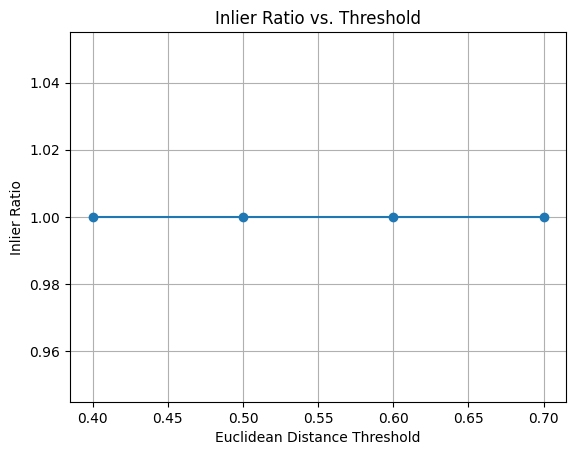

In [30]:
from skimage.measure import ransac

thresholds = [0.4, 0.5, 0.6, 0.7]
results = []

for th in thresholds:
    matches = [(i, j) for i, (j, d) in enumerate(zip(np.argmin(euclid_matrix, axis=1),
                                                     np.min(euclid_matrix, axis=1))) if d < th]
    
    if len(matches) < 3:
        continue  # Can't run RANSAC on < 3 matches

    # Run RANSAC on these matches (you'll implement this in Step 5)
    inliers, affine_matrix, residual = run_ransac(matches, sift_kps_all[0], sift_kps_all[1])

    # Log stats
    results.append({
        'threshold': th,
        'matches': len(matches),
        'inliers': len(inliers),
        'inlier_ratio': len(inliers)/len(matches),
        'residual': residual
    })

# Display or plot results
import pandas as pd
df = pd.DataFrame(results)
print(df)

# Plot (optional)
import matplotlib.pyplot as plt
plt.plot(df['threshold'], df['inlier_ratio'], marker='o')
plt.title("Inlier Ratio vs. Threshold")
plt.xlabel("Euclidean Distance Threshold")
plt.ylabel("Inlier Ratio")
plt.grid(True)
plt.show()
